## Imports

In [1]:
import os
import sys
sys.path.insert(0, '../utils')
import transfer_utils 
import model_utils
import data_utils

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tqdm import tqdm
import numpy as np
import pandas as pd

import torchsummary
import torchvision
import torch
from transfer_model import NTLModel

import warnings
warnings.filterwarnings("ignore")

use_gpu = "cuda" if torch.cuda.is_available() else "cpu"
device = torch.device(use_gpu)
print("Using gpu: ", use_gpu)

%load_ext autoreload
%autoreload 2

DEBUG:matplotlib.pyplot:Loaded backend module://ipykernel.pylab.backend_inline version unknown.


Using gpu:  cpu


## File Locations

In [16]:
# Google Cloud Storage
bucket_name = 'tm-geospatial'
directory = 'poverty-prediction-datasets'
image_directory = directory + '/train_val/train_val_640'

# Destination files
report_file = '../data/zoom18/report/report.csv'
nightlights_unstacked_file = '../data/zoom18/nightlights_unstacked.csv'

dhs_indicators_file = '../data/zoom18/dhs_indicators.csv'
dhs_provinces_file = '../data/zoom18/dhs_provinces.csv'
dhs_regions_file = '../data/zoom18/dhs_regions.csv'

gsm_data_dir = '../data/zoom18//train_val/train_val_640' 
model_file = '../models/zoom18/transfer_model_zoom18.pt'
feature_embeddings_file = '../data/zoom18/embeddingsv2.csv'
embeddings_indicators_file = '../data/zoom18/indicators.csv'

# Test images for sanity checking purposes
high1_file = '../data/test_images/high1.jpg'
high2_file = '../data/test_images/high2.jpg'
low1_file = '../data/test_images/low1.jpg'
low2_file = '../data/test_images/low2.jpg'

## Download Files

## Load Datasets

In [17]:
report = pd.read_csv(report_file)
nightlights_unstacked = pd.read_csv(nightlights_unstacked_file)
dhs_indicators = pd.read_csv(dhs_indicators_file)
dhs_regions = pd.read_csv(dhs_regions_file)
dhs_provinces = pd.read_csv(dhs_provinces_file)

## Instantiate Transfer Model

In [4]:
# Load data
dataloaders, dataset_sizes, class_names = transfer_utils.load_transform_data(
    data_dir=gsm_data_dir, batch_size=4, img_size=640
)

# Instantiate model
model = torchvision.models.vgg16(pretrained=True)
model = NTLModel(model, len(class_names))
if use_gpu == "cuda":
    model = model.cuda()
    
# Load saved model
checkpoint = torch.load(model_file)
model.load_state_dict(checkpoint['state_dict'])

# Visualize model
torchsummary.summary(model, (3, 640, 640))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 640, 640]           1,792
              ReLU-2         [-1, 64, 640, 640]               0
            Conv2d-3         [-1, 64, 640, 640]          36,928
              ReLU-4         [-1, 64, 640, 640]               0
         MaxPool2d-5         [-1, 64, 320, 320]               0
            Conv2d-6        [-1, 128, 320, 320]          73,856
              ReLU-7        [-1, 128, 320, 320]               0
            Conv2d-8        [-1, 128, 320, 320]         147,584
              ReLU-9        [-1, 128, 320, 320]               0
        MaxPool2d-10        [-1, 128, 160, 160]               0
           Conv2d-11        [-1, 256, 160, 160]         295,168
             ReLU-12        [-1, 256, 160, 160]               0
           Conv2d-13        [-1, 256, 160, 160]         590,080
             ReLU-14        [-1, 256, 1

## Visualize Nighttime Light Intensity Classification Predictions

<Figure size 432x288 with 0 Axes>

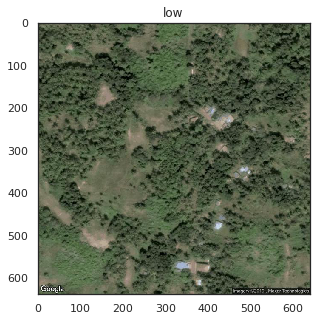

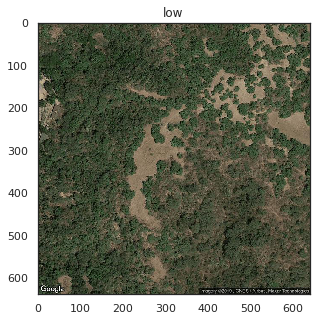

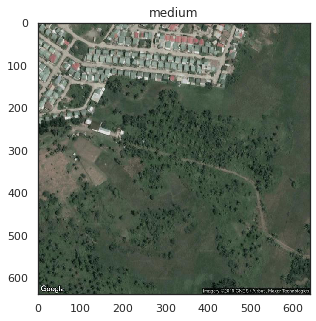

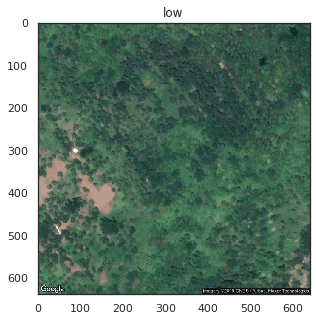

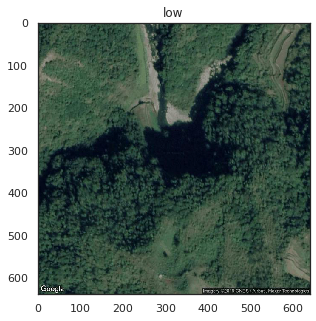

In [6]:
transfer_utils.visualize_model(model, dataloaders, class_names, 5, size=(5,5));

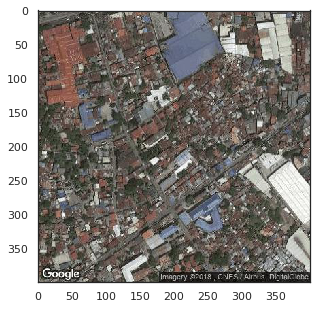

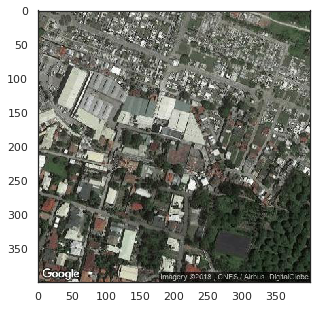

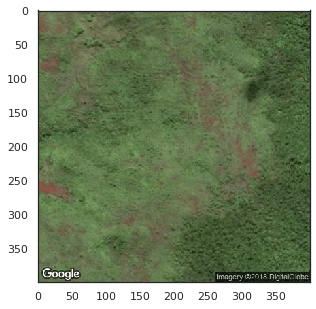

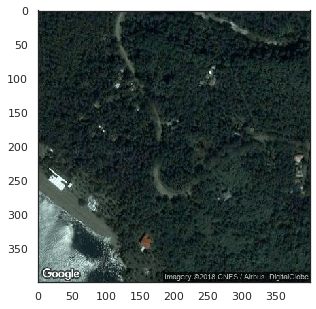

Embedding size: torch.Size([1, 4096])
Cosine similarity between 2 high nightlight intensity images: tensor([0.9744])
Cosine similarity between 2 low nightlight intensity images: tensor([0.9709])
Cosine similarity between 1 low and 1 high: tensor([0.6191])
Cosine similarity 1 high and 1 low: tensor([0.6547])


In [7]:
# Get feature embeddings for selected test images
high1_embedding = transfer_utils.get_embedding(high1_file, model, img_size=640, gpu=True)
high2_embedding = transfer_utils.get_embedding(high2_file, model, img_size=640, gpu=True)
low1_embedding = transfer_utils.get_embedding(low1_file, model, img_size=640, gpu=True)
low2_embedding = transfer_utils.get_embedding(low2_file, model, img_size=640, gpu=True)

# Display test images
figsize = (5,5)
plt.figure(figsize=figsize)
plt.imshow(mpimg.imread(high1_file))
plt.show()
plt.figure(figsize=figsize)
plt.imshow(mpimg.imread(high2_file))
plt.show()
plt.figure(figsize=figsize)
plt.imshow(mpimg.imread(low1_file))
plt.show()
plt.figure(figsize=figsize)
plt.imshow(mpimg.imread(low2_file))
plt.show()

# Sanity check: Get cosine similarity between feature embeddings
cos = torch.nn.CosineSimilarity(dim=1, eps=1e-6)
print("Embedding size: {}".format(high1_embedding.size()))
print('Cosine similarity between 2 high nightlight intensity images: {0}'.format(cos(high1_embedding,high2_embedding)))
print('Cosine similarity between 2 low nightlight intensity images: {0}'.format(cos(low1_embedding,low2_embedding)))
print('Cosine similarity between 1 low and 1 high: {0}'.format(cos(low1_embedding,high2_embedding)))
print('Cosine similarity 1 high and 1 low: {0}'.format(cos(high1_embedding,low2_embedding)))

## Generate feature embedding per cluster

In [13]:
# Get feature embedding per image
#report.filename = report.filename.str.replace('../../data/gsm_data/images/', '../data/images/')
report = nightlights_unstacked.merge(report, left_on='ID', right_on='id', how='left')
report = transfer_utils.get_embedding_per_image(report, model, img_size=640)
print("Report shape: {}".format(report.shape))

# Sanity check: Get feature embedding for 1 high light intensity image and 1 low intensity image
high = torch.from_numpy(np.array([report[report['label'] == 'high'].iloc[0]['embeddings']]))
low = torch.from_numpy(np.array([report[report['label'] == 'low'].iloc[5]['embeddings']]))

# Sanity Check: Cosine similarity between pairs of images
cos = torch.nn.CosineSimilarity(dim=1, eps=1e-6)
print("Cosine similarity is: {}".format(cos(low, high)))

100%|██████████| 173580/173580 [4:21:30<00:00, 11.06it/s]  


Report shape: (173580, 14)
Cosine similarity is: tensor([0.6249])


In [14]:
# Get mean feature embedding per cluster
cluster_embeddings = transfer_utils.get_mean_embedding_per_cluster(report)

# Merge cluster embeddings with DHS indicators
cluster_embeddings = cluster_embeddings.merge(dhs_indicators, left_on='cluster', right_on='Cluster number')
feature_embeddings = cluster_embeddings.mean_embedding.apply(pd.Series)

# Save embeddings 
feature_embeddings.to_csv(feature_embeddings_file)
cluster_embeddings.to_csv(embeddings_indicators_file)

100%|██████████| 1214/1214 [00:02<00:00, 584.20it/s]


## Machine Learning Pipeline

In [18]:
scoring = {
    'r2': data_utils.pearsonr2,
    'rmse': data_utils.rmse
}

indicators = [
    'Wealth Index',
    'Education completed (years)',
    'Access to electricity',
    'Access to water (minutes)'
]

In [19]:
# Load embedding features
embeddings_df = pd.read_csv(feature_embeddings_file).iloc[:, 1:]
cluster_embeddings = pd.read_csv(embeddings_indicators_file)

region_cols = list(dhs_regions.columns[:-1])
province_cols = list(dhs_provinces.columns[:-1])
embedding_cols = list(embeddings_df.columns) 

# Merge with DHS indicators
embeddings_df['Cluster number'] = cluster_embeddings['Cluster number']
data = embeddings_df.merge(cluster_embeddings, on='Cluster number')

# Merge with regional and provincial indicators
data = data.merge(dhs_provinces, on='Cluster number', how='left')
data = data.merge(dhs_regions, on='Cluster number', how='left')
data = data.fillna(0)

print(data.shape)

(1213, 4209)


## t-SNE Visualization

In [6]:
embeddings = data.iloc[:, :4096]
feature_cols = embeddings.columns

embeddings['Cluster number'] = data['Cluster number']
embeddings['Wealth Index'] = data['Wealth Index']

# Sanity check embeddings
data.iloc[:, [-7, 0, 1, 2]].tail(3)

,Ilocos,0,1,2
1210,0,0.190383,0.439995,0.178736
1211,0,0.206407,0.394210,0.153873
1212,0,0.142342,0.372011,0.147608


In [7]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(embeddings[feature_cols].values)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1213 samples in 0.321s...
[t-SNE] Computed neighbors for 1213 samples in 8.206s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1213
[t-SNE] Computed conditional probabilities for sample 1213 / 1213
[t-SNE] Mean sigma: 1.296462
[t-SNE] KL divergence after 250 iterations with early exaggeration: 58.020092
[t-SNE] KL divergence after 300 iterations: 0.736889


DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f5ed4b9ce10>
DEBUG:matplotlib.colorbar:Using auto colorbar locator on colorbar
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f5ed4b9ce10>
DEBUG:matplotlib.colorbar:Setting pcolormesh


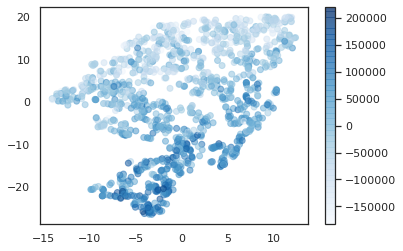

In [19]:
embeddings['x-tsne'] = tsne_results[:,0]
embeddings['y-tsne'] = tsne_results[:,1]

f, ax = plt.subplots()
points = ax.scatter(embeddings['x-tsne'], embeddings['y-tsne'], c=embeddings['Wealth Index'], cmap='Blues', alpha=0.5)
f.colorbar(points)

## Machine Learning Pipeline

In [30]:
data[region_cols]

,Autonomous Region in Muslim Mindanao,Bicol,Cagayan Valley,Calabarzon,Caraga,Central Luzon,Central Visayas,Cordillera,Davao,Eastern Visayas,Ilocos,Mimaropa,National Capital,Northern Mindanao,Soccsksargen,Western Visayas,Zamboanga Peninsula
0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1208,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
1209,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
1210,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
1211,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0


In [23]:
from sklearn.linear_model import Ridge
import pickle
model = Ridge(alpha=1.49816047538945, copy_X=True, fit_intercept=True, max_iter=None, normalize=False, random_state=42, solver='auto', tol=0.001)
model.fit(data[embedding_cols+region_cols], data[indicators[0]])
filename = '../models/wealth_model_zoom18.pt'
pickle.dump(model, open(filename, 'wb'))

Socioeconomic indicator: Wealth Index
fit_time : 3.8059
[3.79652572 3.76675749 3.78593946 3.82000709 3.86025357]
score_time : 0.0086
[0.0082593  0.00882864 0.00846457 0.00830388 0.00904751]
test_r2 : 0.6256
[0.68084078 0.57414404 0.63082776 0.6234913  0.61873454]
train_r2 : 0.7356
[0.7185312  0.72673424 0.7317197  0.73342338 0.76778523]
test_rmse : 43232.1098
[41037.14130471 42038.77217125 47665.74743326 42849.87733343
 42569.01098426]
train_rmse : 36613.4064
[37534.48544202 38083.73305202 35871.34833173 36930.61601801
 34646.84911221]


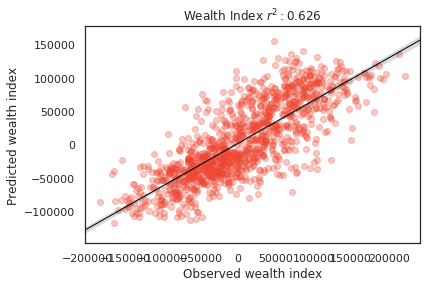

Best estimator: Pipeline(memory=None,
         steps=[('regressor',
                 Ridge(alpha=1.49816047538945, copy_X=True, fit_intercept=True,
                       max_iter=None, normalize=False, random_state=42,
                       solver='auto', tol=0.001))],
         verbose=False)
Socioeconomic indicator: Education completed (years)
fit_time : 3.9519
[3.83519173 3.85171819 3.84451127 4.15718079 4.0709188 ]
score_time : 0.0095
[0.00863194 0.00942492 0.01003408 0.00967431 0.00974393]
test_r2 : 0.4615
[0.51950753 0.36567927 0.527168   0.46930239 0.42566862]
train_r2 : 0.5944
[0.59093578 0.60045723 0.56741732 0.60076148 0.61233594]
test_rmse : 1.7193
[1.61862496 1.67887612 1.8119035  1.75263404 1.7344482 ]
train_rmse : 1.5018
[1.51311805 1.53106376 1.50269297 1.48241541 1.47954973]


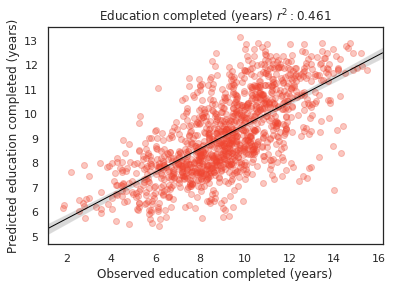

Best estimator: Pipeline(memory=None,
         steps=[('regressor',
                 Ridge(alpha=2.9279757672456204, copy_X=True,
                       fit_intercept=True, max_iter=None, normalize=False,
                       random_state=42, solver='auto', tol=0.001))],
         verbose=False)
Socioeconomic indicator: Access to electricity
fit_time : 3.8021
[3.79165959 3.77730703 3.76617861 3.84033751 3.83488464]
score_time : 0.0087
[0.00967145 0.00872278 0.00863957 0.00804305 0.00861931]
test_r2 : 0.3141
[0.27899897 0.27895558 0.42639832 0.3248556  0.26106154]
train_r2 : 0.5127
[0.53814685 0.52904204 0.42322923 0.53034963 0.54296726]
test_rmse : 0.1207
[0.11847161 0.11569587 0.1502856  0.12025953 0.09872496]
train_rmse : 0.1022
[0.10132571 0.10271194 0.10113417 0.10084567 0.10511668]


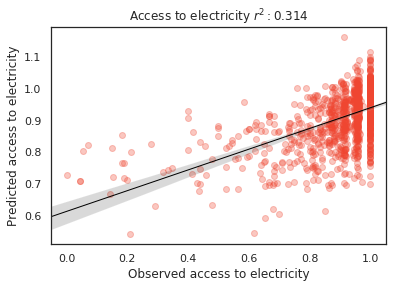

Best estimator: Pipeline(memory=None,
         steps=[('regressor',
                 Ridge(alpha=1.49816047538945, copy_X=True, fit_intercept=True,
                       max_iter=None, normalize=False, random_state=42,
                       solver='auto', tol=0.001))],
         verbose=False)
Socioeconomic indicator: Access to water (minutes)
fit_time : 3.8464
[3.7836411  3.80406308 3.82178235 3.93488789 3.88774228]
score_time : 0.0090
[0.00904107 0.00884724 0.00931692 0.00933862 0.00867558]
test_r2 : 0.1280
[0.12394894 0.18938421 0.0625698  0.13933511 0.12488524]
train_r2 : 0.3160
[0.25415768 0.31456991 0.35957301 0.32543814 0.32639604]
test_rmse : 7.3512
[11.63985974  3.70921798  8.29679772  7.71774743  5.39243972]
train_rmse : 6.9146
[5.95908198 7.60647384 6.71218374 6.91667191 7.37867302]


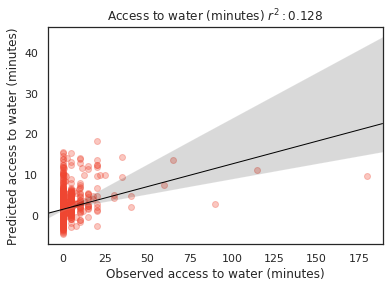

Best estimator: Pipeline(memory=None,
         steps=[('regressor',
                 Ridge(alpha=3.8028572256396647, copy_X=True,
                       fit_intercept=True, max_iter=None, normalize=False,
                       random_state=42, solver='auto', tol=0.001))],
         verbose=False)


In [21]:
predictions = model_utils.evaluate_model(
    data=data,
    feature_cols=embedding_cols+region_cols, 
    indicator_cols=indicators, 
    scoring=scoring,
    model_type='ridge', 
    refit='r2', 
    search_type='grid', 
    n_splits=5 ,
    n_workers=1
)

### Using CNN feature embeddings + Regional indicators

Socioeconomic indicator: Wealth Index
fit_time : 2.2965
[2.34996963 2.27236485 2.25133872 2.29055452 2.3180964 ]
score_time : 0.0051
[0.00527501 0.00502157 0.00512505 0.00509977 0.00504351]
test_r2 : 0.6256
[0.68084078 0.57414404 0.63082776 0.6234913  0.61873454]
train_r2 : 0.7356
[0.7185312  0.72673424 0.7317197  0.73342338 0.76778523]
test_rmse : 43232.1098
[41037.14130472 42038.77217125 47665.74743326 42849.87733343
 42569.01098426]
train_rmse : 36613.4064
[37534.48544202 38083.73305202 35871.34833173 36930.61601801
 34646.84911221]


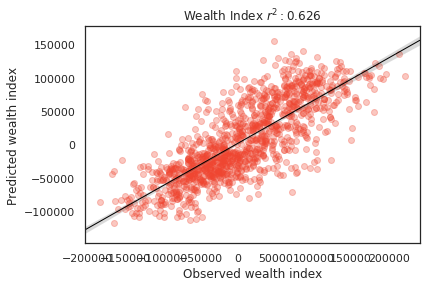

Best estimator: Pipeline(memory=None,
         steps=[('regressor',
                 Ridge(alpha=1.49816047538945, copy_X=True, fit_intercept=True,
                       max_iter=None, normalize=False, random_state=42,
                       solver='auto', tol=0.001))],
         verbose=False)
Socioeconomic indicator: Education completed (years)
fit_time : 2.3011
[2.35834408 2.25151849 2.32160091 2.29488206 2.27923036]
score_time : 0.0051
[0.00503945 0.0051477  0.00533128 0.00504422 0.00517917]
test_r2 : 0.4615
[0.51950753 0.36567927 0.527168   0.46930239 0.42566862]
train_r2 : 0.5944
[0.59093578 0.60045723 0.56741732 0.60076148 0.61233594]
test_rmse : 1.7193
[1.61862496 1.67887612 1.8119035  1.75263404 1.7344482 ]
train_rmse : 1.5018
[1.51311805 1.53106376 1.50269297 1.48241541 1.47954973]


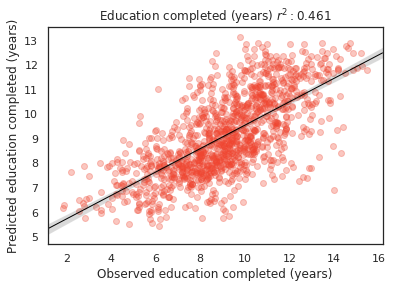

Best estimator: Pipeline(memory=None,
         steps=[('regressor',
                 Ridge(alpha=2.9279757672456204, copy_X=True,
                       fit_intercept=True, max_iter=None, normalize=False,
                       random_state=42, solver='auto', tol=0.001))],
         verbose=False)
Socioeconomic indicator: Access to electricity
fit_time : 2.2759
[2.24420381 2.25770712 2.24341226 2.32995796 2.30408478]
score_time : 0.0052
[0.00521135 0.00514364 0.00501609 0.00525522 0.00546718]
test_r2 : 0.3141
[0.27899897 0.27895558 0.42639832 0.3248556  0.26106154]
train_r2 : 0.5127
[0.53814685 0.52904204 0.42322923 0.53034963 0.54296726]
test_rmse : 0.1207
[0.11847161 0.11569587 0.1502856  0.12025953 0.09872496]
train_rmse : 0.1022
[0.10132571 0.10271194 0.10113417 0.10084567 0.10511668]


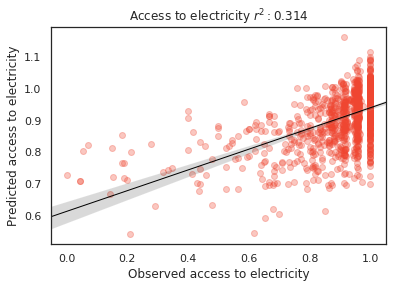

Best estimator: Pipeline(memory=None,
         steps=[('regressor',
                 Ridge(alpha=1.49816047538945, copy_X=True, fit_intercept=True,
                       max_iter=None, normalize=False, random_state=42,
                       solver='auto', tol=0.001))],
         verbose=False)
Socioeconomic indicator: Access to water (minutes)
fit_time : 2.2996
[2.26766634 2.25873446 2.28596783 2.28661704 2.39879704]
score_time : 0.0053
[0.00502539 0.00523829 0.00581026 0.00524616 0.00498223]
test_r2 : 0.1280
[0.12394894 0.18938421 0.0625698  0.13933511 0.12488524]
train_r2 : 0.3160
[0.25415768 0.31456991 0.35957301 0.32543814 0.32639604]
test_rmse : 7.3512
[11.63985974  3.70921798  8.29679772  7.71774743  5.39243972]
train_rmse : 6.9146
[5.95908198 7.60647384 6.71218374 6.91667191 7.37867302]


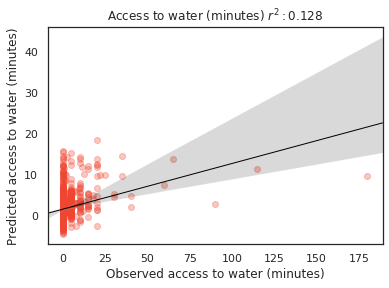

Best estimator: Pipeline(memory=None,
         steps=[('regressor',
                 Ridge(alpha=3.8028572256396647, copy_X=True,
                       fit_intercept=True, max_iter=None, normalize=False,
                       random_state=42, solver='auto', tol=0.001))],
         verbose=False)


In [21]:
predictions = model_utils.evaluate_model(
    data=data,
    feature_cols=embedding_cols+region_cols, 
    indicator_cols=indicators, 
    scoring=scoring,
    model_type='ridge', 
    refit='r2', 
    search_type='grid', 
    n_splits=5 ,
    n_workers=1
)

### Using CNN feature embeddings 

Socioeconomic indicator: Wealth Index
fit_time : 2.2571
[2.22900438 2.22844028 2.24881721 2.3146565  2.26440382]
score_time : 0.0055
[0.00539923 0.0052762  0.00567794 0.00584078 0.00533533]
test_r2 : 0.5851
[0.62865615 0.53313353 0.61709878 0.58469824 0.56179501]
train_r2 : 0.7279
[0.72613948 0.70004568 0.73210077 0.73822238 0.74276702]
test_rmse : 45498.3776
[44243.31345299 44040.72088885 48573.18616457 45005.37748183
 45629.28981885]
train_rmse : 37282.7650
[37176.50391764 39955.2620297  35997.95198855 36742.18425603
 36541.92264772]


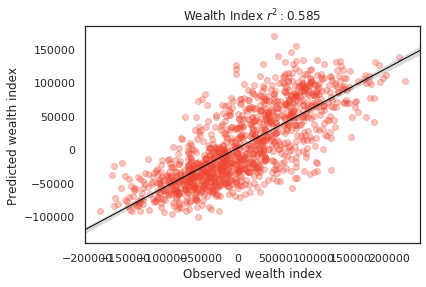

Best estimator: Pipeline(memory=None,
         steps=[('regressor',
                 Ridge(alpha=1.49816047538945, copy_X=True, fit_intercept=True,
                       max_iter=None, normalize=False, random_state=42,
                       solver='auto', tol=0.001))],
         verbose=False)
Socioeconomic indicator: Education completed (years)
fit_time : 2.2509
[2.22703457 2.24417019 2.24076915 2.25874567 2.28362751]
score_time : 0.0054
[0.00533724 0.00572205 0.00539589 0.00527644 0.00534582]
test_r2 : 0.4409
[0.47808378 0.35185738 0.51685152 0.46300213 0.39447028]
train_r2 : 0.5914
[0.61959747 0.57085228 0.55506884 0.5719569  0.63933432]
test_rmse : 1.7533
[1.68685217 1.69644201 1.83717956 1.76316928 1.7827955 ]
train_rmse : 1.5099
[1.46624921 1.58726011 1.52636848 1.53601947 1.43356359]


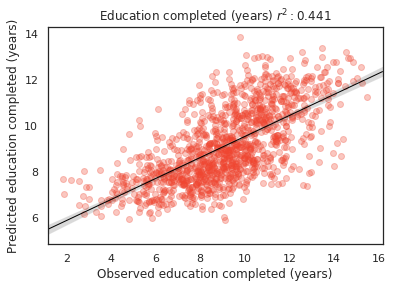

Best estimator: Pipeline(memory=None,
         steps=[('regressor',
                 Ridge(alpha=1.49816047538945, copy_X=True, fit_intercept=True,
                       max_iter=None, normalize=False, random_state=42,
                       solver='auto', tol=0.001))],
         verbose=False)
Socioeconomic indicator: Access to electricity
fit_time : 2.2426
[2.26906538 2.21368361 2.22103286 2.25592613 2.25321126]
score_time : 0.0054
[0.00540328 0.00554085 0.00540495 0.00548983 0.00539637]
test_r2 : 0.2701
[0.20593402 0.23590294 0.34609993 0.32229153 0.24045214]
train_r2 : 0.4777
[0.48890582 0.47445073 0.46041653 0.47078792 0.49407301]
test_rmse : 0.1242
[0.12483221 0.11834734 0.15768904 0.12052234 0.09946198]
train_rmse : 0.1067
[0.10705344 0.10896396 0.09879486 0.10763547 0.1112716 ]


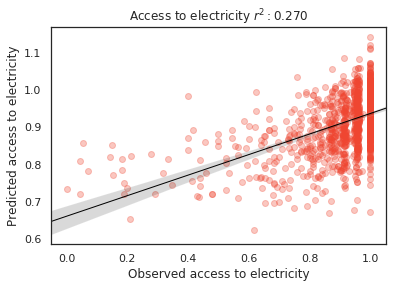

Best estimator: Pipeline(memory=None,
         steps=[('regressor',
                 Ridge(alpha=1.49816047538945, copy_X=True, fit_intercept=True,
                       max_iter=None, normalize=False, random_state=42,
                       solver='auto', tol=0.001))],
         verbose=False)
Socioeconomic indicator: Access to water (minutes)
fit_time : 2.2692
[2.2609911  2.26559162 2.25872827 2.2692287  2.29122376]
score_time : 0.0054
[0.00550461 0.00538182 0.00529218 0.00525308 0.00551605]
test_r2 : 0.0601
[0.03717959 0.11312961 0.05119876 0.04846511 0.05070238]
train_r2 : 0.1614
[0.32224589 0.09733998 0.12646788 0.09862589 0.16230102]
test_rmse : 7.5095
[12.02811624  3.7260037   8.29822704  8.10814642  5.38723059]
train_rmse : 7.5979
[5.81325906 8.56183555 7.6736384  7.80265394 8.138059  ]


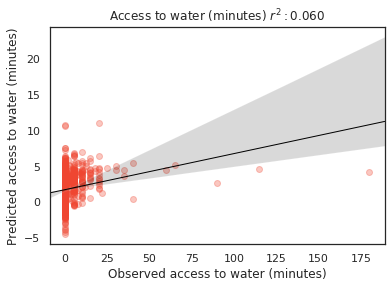

Best estimator: Pipeline(memory=None,
         steps=[('regressor',
                 Ridge(alpha=2.9279757672456204, copy_X=True,
                       fit_intercept=True, max_iter=None, normalize=False,
                       random_state=42, solver='auto', tol=0.001))],
         verbose=False)


In [22]:
predictions = model_utils.evaluate_model(
    data=data,
    feature_cols=embedding_cols, 
    indicator_cols=indicators, 
    scoring=scoring,
    model_type='ridge', 
    refit='r2', 
    search_type='grid', 
    n_splits=5,
    n_workers=1
)